## 1.7 使用Word Embedding实现中文自动摘要
###  1.7.1 背景说明
### 1.7.2 使用jieba分词

In [4]:
import jieba
import numpy as np

filePath='./data/corpus.txt'
fileSegWordDonePath ='corpusSegDone_1.txt'

# 打印中文列表
def PrintListChinese(list):
    for i in range(len(list)):
        print (list[i]) 
                
# 读取文件内容到列表
fileTrainRead = []
with open(filePath,'r') as fileTrainRaw:
    for line in fileTrainRaw:  # 按行读取文件
        fileTrainRead.append(line)
    

# jieba分词后保存在列表中
fileTrainSeg=[]
for i in range(len(fileTrainRead)):
    fileTrainSeg.append([' '.join(list(jieba.cut(fileTrainRead[i][9:-11],cut_all=False)))])
    if i % 10000 == 0:
        print(i)
        

# 保存分词结果到文件中
with open(fileSegWordDonePath,'w',encoding='utf-8') as fW:
    for i in range(len(fileTrainSeg)):
        fW.write(fileTrainSeg[i][0])
        fW.write('\n')       


FileNotFoundError: [Errno 2] No such file or directory: './data/corpus.txt'

In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.6 MB/s eta 0:00:00


### 1.7.3 生成Embedding

In [5]:
"""
gensim word2vec获取词向量
"""

import warnings
import logging
import os.path
import sys
import multiprocessing

import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
# 忽略警告
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
 
if __name__ == '__main__':
    
    program = os.path.basename(sys.argv[0]) # 读取当前文件的文件名
    logger = logging.getLogger(program)
    logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s',level=logging.INFO)
    logger.info("running %s" % ' '.join(sys.argv))
 
    # inp为输入语料, outp1为输出模型, outp2为vector格式的模型
    inp = 'corpusSegDone_1.txt'
    out_model = 'corpusSegDone_1.model'
    out_vector = 'corpusSegDone_1.vector'
 
    # 训练skip-gram模型
    model = Word2Vec(LineSentence(inp), size=50, window=5, min_count=5,
                     workers=multiprocessing.cpu_count())
 
    # 保存模型
    model.save(out_model)
    # 保存词向量
    model.wv.save_word2vec_format(out_vector, binary=False)

2023-11-18 13:49:42,496: INFO: running /Users/lhc456/miniconda/envs/tf_test/lib/python3.10/site-packages/ipykernel_launcher.py -f /Users/lhc456/Library/Jupyter/runtime/kernel-18206cdc-4580-4f7d-9f20-cf1f1569b590.json


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

### 1.7.4 把文档的词转换为词向量

In [4]:
# 采用Word2Vec词聚类方法抽取关键词1——获取文本词向量表示
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')  # 忽略警告
import sys, codecs
import pandas as pd
import numpy as np
import jieba
import jieba.posseg
import gensim

# 返回特征词向量
def getWordVecs(wordList, model):
    name = []
    vecs = []
    for word in wordList:
        word = word.replace('\n', '')
        try:
            if word in model:  # 模型中存在该词的向量表示
                #name.append(word.encode('utf8'))
                name.append(word)
                vecs.append(model[word])
        except KeyError:
            continue
    a = pd.DataFrame(name, columns=['word'])
    b = pd.DataFrame(np.array(vecs, dtype='float'))
    return pd.concat([a, b], axis=1)

# 数据预处理操作：分词，去停用词，词性筛选
def dataPrepos(text, stopkey):
    l = []
    pos = ['n', 'nz', 'v', 'vd', 'vn', 'l', 'a', 'd']  # 定义选取的词性
    seg = jieba.posseg.cut(text)  # 分词
    for i in seg:
        if i.word not in l and i.word not in stopkey and i.flag in pos:  # 去重 + 去停用词 + 词性筛选
            # print i.word
            l.append(i.word)
    return l

# 根据数据获取候选关键词词向量
def buildAllWordsVecs(data, stopkey, model):
    idList, titleList, abstractList = data['id'], data['title'], data['abstract']
    for index in range(len(idList)):
        id = idList[index]
        title = titleList[index]
        abstract = abstractList[index]
        l_ti = dataPrepos(title, stopkey)  # 处理标题
        l_ab = dataPrepos(abstract, stopkey)  # 处理摘要
        # 获取候选关键词的词向量
        words = np.append(l_ti, l_ab)  # 拼接数组元素
        words = list(set(words))  # 数组元素去重,得到候选关键词列表
        wordvecs = getWordVecs(words, model)  # 获取候选关键词的词向量表示
        # 词向量写入csv文件，每个词400维
        data_vecs = pd.DataFrame(wordvecs)
        data_vecs.to_csv('wordvecs_' + str(id) + '.csv', index=False)
        print("document ", id, " well done.")

def main():
    # 读取数据集
    dataFile = 'sample_data.csv'
    data = pd.read_csv(dataFile)
    # 停用词表
    stopkey = [w.strip() for w in codecs.open('stopWord.txt', 'r').readlines()]
    # 词向量模型
    inp = 'corpusSegDone_1.vector'
    model = gensim.models.KeyedVectors.load_word2vec_format(inp, binary=False)
    buildAllWordsVecs(data, stopkey, model)

if __name__ == '__main__':
    main()



2020-08-12 19:40:43,823: INFO: loading projection weights from corpusSegDone_1.vector
2020-08-12 19:41:05,251: INFO: loaded (382751, 50) matrix from corpusSegDone_1.vector


document  1  well done.
document  2  well done.
document  3  well done.
document  4  well done.
document  5  well done.
document  6  well done.
document  7  well done.
document  8  well done.
document  9  well done.
document  10  well done.


### 1.7.5 生成各主题的关键词
采用聚类方法对候选关键词的词向量进行聚类分析，实现代码如下

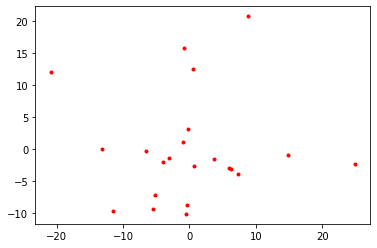

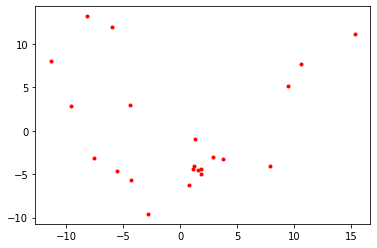

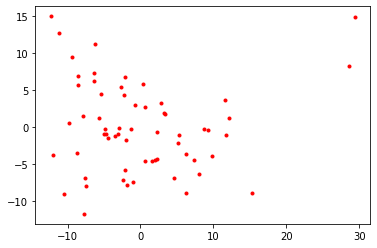

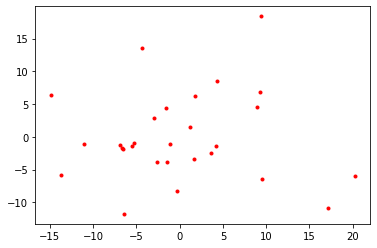

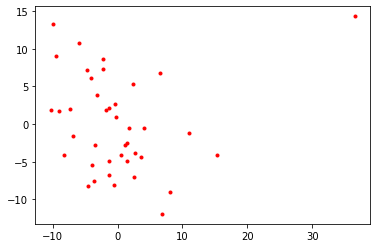

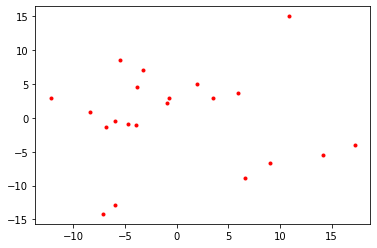

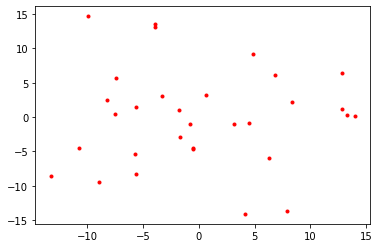

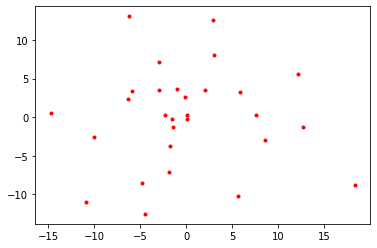

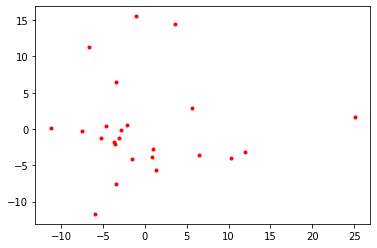

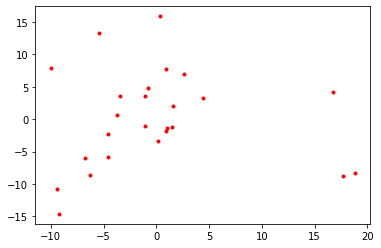

In [16]:
# 采用Word2Vec词聚类方法抽取关键词2——根据候选关键词的词向量进行聚类分析
import sys,os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# 对词向量采用K-means聚类抽取TopK关键词
topK=6
def getkeywords_kmeans(data,topK):
    words = data["word"] # 词汇
    vecs = data.iloc[:,1:] # 向量表示

    kmeans = KMeans(n_clusters=1,random_state=10).fit(vecs)
    labels = kmeans.labels_ #类别结果标签
    labels = pd.DataFrame(labels,columns=['label'])
    new_df = pd.concat([labels,vecs],axis=1)
    df_count_type = new_df.groupby('label').size() #各类别统计个数
    # print df_count_type
    vec_center = kmeans.cluster_centers_ #聚类中心

    # 计算距离（相似性） 采用欧几里得距离（欧式距离）
    distances = []
    vec_words = np.array(vecs) # 候选关键词向量，dataFrame转array
    vec_center = vec_center[0] # 第一个类别聚类中心,本例只有一个类别
    length = len(vec_center) # 向量维度
    for index in range(len(vec_words)): # 候选关键词个数
        cur_wordvec = vec_words[index] # 当前词语的词向量
        dis = 0 # 向量距离
        for index2 in range(length):
            dis += (vec_center[index2]-cur_wordvec[index2])*(vec_center[index2]-cur_wordvec[index2])
        dis = math.sqrt(dis)
        distances.append(dis)
    distances = pd.DataFrame(distances,columns=['dis'])

    result = pd.concat([words, labels ,distances], axis=1) # 拼接词语与其对应中心点的距离
    result = result.sort_values(by="dis",ascending = True) # 按照距离大小进行升序排序

    # 将用于聚类的数据的特征维度降到2维
    pca = PCA(n_components=2)
    new_pca = pd.DataFrame(pca.fit_transform(new_df))
    #print new_pca
    #可视化
    d = new_pca[new_df['label'] == 0]
    plt.plot(d[0],d[1],'r.')
    d = new_pca[new_df['label'] == 1]
    plt.plot(d[0], d[1], 'go')
    d = new_pca[new_df['label'] == 2]
    plt.plot(d[0], d[1], 'b*')
    plt.gcf().savefig('kmeans.png')
    plt.show()

    # 抽取排名前topK个词语作为文本关键词
    wordlist = np.array(result['word']) # 选择词汇列并转成数组格式
    word_split = [wordlist[x] for x in range(0,topK)] # 抽取前topK个词汇
    word_split = " ".join(word_split)
    return word_split

def main():
    # 读取数据集
    dataFile = 'sample_data.csv'
    articleData = pd.read_csv(dataFile)
    ids, titles, keys = [], [], []

    rootdir = "vecs" # 词向量文件根目录
    fileList = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    # 遍历文件
    for i in range(len(fileList)):
        filename = fileList[i]
        path = os.path.join(rootdir,filename)
        if os.path.isfile(path):
            data = pd.read_csv(path) # 读取词向量文件数据
            #data = pd.read_csv(path)
            artile_keys = getkeywords_kmeans(data,topK) # 聚类算法得到当前文件的关键词
            #print(artile_keys)
            #break
            artile_keys=artile_keys
            # 根据文件名获得文章id以及标题
            (shortname, extension) = os.path.splitext(filename) # 得到文件名和文件扩展名
            t = shortname.split("_")
            article_id = int(t[len(t)-1]) # 获得文章id
            artile_tit = articleData[articleData.id==article_id]['title'] # 获得文章标题
            artile_tit = list(artile_tit)[0] # series转成字符串
            ids.append(article_id)
            titles.append(artile_tit)            
            keys.append(artile_keys)
            #keys.append(artile_keys)
    # 所有结果写入文件
    result = pd.DataFrame({"id": ids, "title": titles, "key": keys}, columns=['id', 'title', 'key'])
    result = result.sort_values(by="id",ascending=True) # 排序
    result.to_csv("result/keys_word2vec.csv", index=False)

if __name__ == '__main__':
    main()




### 1.7.6 查了结果

1）查看原材料前 4 个主题及概要信息，结果如下

In [22]:
#查看原文件各主题及其概要说明
! head -3 sample_data.csv

2）生成的各主题关键词，结果如下：

In [21]:
#查看各主题提炼的关键字
! head -3 result/keys_word2vec.csv

id,title,key
1,永磁电机驱动的纯电动大巴车坡道起步防溜策略,力矩 开度 设定值 坡道 闭环控制 使能
2,机动车辆车门的肘靠,溃缩 衬板 元件 交叉 凹陷 机动车辆
